In [1]:
%load_ext autoreload
%autoreload 1
    
%aimport qPCR

import qPCR as q
import pandas as pd, numpy as np
import math

from qPCR import average_cq, tidy_df
from numpy import power, log, asarray
from scipy import stats
from scipy.stats.mstats import gmean

import matplotlib.pyplot as plt
import seaborn as sns


import re
%matplotlib inline

ModuleNotFoundError: No module named 'qPCR'

In [2]:
def amean_cq(seq):
    amean_cq = np.mean(seq)
    return amean_cq

def delta_delta_cq(control_avg, sample_avg):
    dcq = control_avg - sample_avg
    ddcq = power(2, dcq)
    return ddcq

log2 = lambda x: log(x)/log(2)

def stats_rq(RQ):

    log2_RQ = log2(RQ)
    sd_RQ   = np.std(log2_RQ, ddof=1)
    sem_RQ  = stats.sem(log2_RQ)
    
    bio_gmean_RQ  = gmean(RQ)
    log2_gmean_RQ = log2(bio_gmean_RQ)
    
    
    # 95% confidence interval [in this case a t statistic of 4.3 was used based on three samples per biological group (i.e., 2 degrees of freedom)]
    # of each group are then calculated from the log transformed normalized expression (columns 12–15
    
#     ci_low  = power(1+sd_RQ, log2_gmean_RQ )
#     ci_upp  =
    
    return sd_RQ, log2_gmean_RQ, sem_RQ


'''qPCR Calculations and Error Propagation
The data analysis and associated calculations for relative quantification involve multiple steps (Figure 5):
(i) extract the Cq values for each sample after inter-run calibration and calculate the mean Cq from the associated technical replicates;

(ii) determine the relative quantity by raisingone + the PCR efficiency (E) [determined from the standard curve (Figure 4C)] to the DCq [i.e., (1 + E)DCq];
(calculated by subtracting the mean Cq of all the samples within the control group from the mean Cq of the technical replicates
from each sample);

(iii) enumerate the normal- ized relative expression (equivalent to DDCq after log transformation) per sample by dividing
the relative quantity of a given target/sample (step 2) by the geometric mean of the relative quantities of two or more reference targets;

(iv) compute the average normalized expression of the samples in each biological group; and

(v) perform statistical analysis based on the log
transformed normalized expression per sample (Figure 5: column 9) [41].These calculations are complex because qPCR data are relative by nature
between samples or groups of samples, with normalization to reference genes, and calibration between plates. Additionally, qPCR measurements
are made on the log scale (Cq value) with statistical analysis performed in Cq space (i.e., DDCq values or using log-transformed relative
normal- ized expression), while expression levels are reported after linear transformation of the DDCq results.'''


untreated = [1.05, 0.92, 1.04]
treated   = [0.27, 0.74, 0.40]
u_sd, u_lgmean, u_sem = stats_rq(untreated)
t_sd, t_lgmean, t_sem = stats_rq(treated)

# ci_low  = power(1+u_sd, u_lgmean-(4.3)*u_sem)

ci_low  = power(1+0.11, 0-(4.3)*0.06)
ci_upp  = power(1+0.11, 0+(4.3)*0.06)




t = stats.ttest_ind(untreated, treated, equal_var = True)
ci_low, ci_upp

(0.9734343593185913, 1.0272906338543513)

In [59]:
def analyse_df(sample_df, ref_target, treatment=False):
    """Description 
    
    :param DataFrame sample_frame: A sample data frame.
    :param string ref_target: A string matching an entry of the Target column; reference gene;
        the target to use as the reference target (e.g. 'BACTIN')
    :return: A DataFrame with columns: Sample, Target, Age, DeltaCq, and Rel Exp.
    :rtype: DataFrame
    """
    
    relevant_cols = ['Sample', 'Cq', 'Condition', 'Bio Rep']
    relevant_grps = ['Condition', 'Sample', 'Bio Rep']
    if treatment: relevant_cols.append('Treatment'); relevant_grps.append('Treatment')

    if isinstance(sample_df,list): sample_df = sample_df[0]
        
    # select relevant columns from reference gene data and find mean of technical replicates
    ref_target_df             = sample_df.loc[sample_df['Target'] == ref_target, relevant_cols]
    ref_target_grouped_by_age = ref_target_df.groupby(relevant_grps)
    ref_target_mean_by_sample = ref_target_grouped_by_age.agg(amean_cq)
    
    ref_target_mean_by_treat  = ref_target_mean_by_sample.groupby(['Treatment','Condition']).agg(amean_cq)
    
    ref_sample_grouped_by_age = sample_df.groupby(relevant_grps)
    
#     print(ref_target_mean_by_sample, ref_target_mean_by_treat,ref_sample_grouped_by_age.groups)
    # define conditions and initiate empty array and df
    unique_conditions = sample_df.Condition.unique()
    sample_dcq_series = []
    analysed_df       = pd.DataFrame({
                           'Sample': [],
                           'Target': [],
                           'Age': [],
                           'RQ': [],
                           'Avg RQ': [],
                           'Treatment': []
                          })
    
    # iterate through unique 'conditions' i.e. ages and NEG, calculate relative quantity, and 
    for condition, group in ref_sample_grouped_by_age:
#         print(condition, group)
        for age in unique_conditions:
            if age == condition[0]:
                sample         = condition[1]
                ref_mean_cq    = ref_target_mean_by_sample.loc[[age, 'average_cq']]['Cq'][0]
                sample_mean_cq = amean_cq(group['Cq']) # arithmetic mean of tech reps
                
                biorep    = group['Bio Rep'].unique()[0]
                treatment = group['Treatment'].unique()[0]
                
                print(biorep, treatment,'end')
                
                print(ref_target_mean_by_sample.index, ref_target_mean_by_sample.loc[age])
                
                
                dct = ref_mean_cq - sample_mean_cq
#                 print(sample, ref_mean_cq, sample_mean_cq, dct)
#                 RQ      = delta_delta_cq(ref_mean_cq,sample_mean_cq)
#                 log2_RQ = log(RQ)
#                 print(ref_target_mean_by_sample.loc[[age, 'average_cq']]['Cq'])

                sample_cq      = group['Cq']
                RQs            = delta_delta_cq(ref_mean_cq,sample_cq)#
                sd, sem, gmean = stats_rq(RQs)

                for RQ in RQs:
                    analysed_df = analysed_df.append({
                           'Sample'   : sample,
                           'Target'   : group['Target'].unique()[0],
                           'Age'      : age,
                           'RQ'       : RQ,
                           'Avg RQ'   : gmean,
                           'Treatment': group['Treatment'].unique()[0]}
                             ,ignore_index=True)

    return 0 #analysed_df
    

'''
1. average tech reps
2. normalise to bactin - dct from each sample (bio duplicate) - sample control
3. get relative expression for each sample
4. take mean of rq of bio replicates
5. fold change relative to biological control (1A?) - i.e. normalise again to day 3 1A non gravel - plot this.

'''
    

# analysed_df = analyse_df(tidy_df(df_pt1, True), 'BACTIN', treatment=True)
# analysed_df 

path_fake   = "../../Analyses/fake/"
fname_fake  = ["fake3"]
fake_df     = tidy_multi_df(path_fake, fname_fake, True)

analyse     = analyse_df(fake_df, 'BACTIN', True)
# fake_df

1 Gravel end
MultiIndex(levels=[['3', '5', '7', 'NEG'], ['3_BACTIN_1', '3_BACTIN_2', '5_BACTIN_1', '5_BACTIN_2', '7_BACTIN_1', '7_BACTIN_2', 'NEG_BACTIN_1', 'NEG_BACTIN_2'], ['1', '2'], ['Gravel', 'Non Gravel']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7], [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['Condition', 'Sample', 'Bio Rep', 'Treatment'])                                       Cq
Sample     Bio Rep Treatment            
3_BACTIN_1 1       Gravel       3.666667
                   Non Gravel   6.000000
3_BACTIN_2 2       Gravel       5.333333
                   Non Gravel  13.666667
1 Non Gravel end
MultiIndex(levels=[['3', '5', '7', 'NEG'], ['3_BACTIN_1', '3_BACTIN_2', '5_BACTIN_1', '5_BACTIN_2', '7_BACTIN_1', '7_BACTIN_2', 'NEG_BACTIN_1', 'NEG_BACTIN_2'], ['1', '2'], ['Gravel', 'Non Gravel']],
           labels=[[0, 0, 0, 0, 1, 1, 

In [4]:

def read_multi_csv(path, fname_arr):
    # Reads multiple csv files. Input path of file and
    # array of filenames assuming they are in the same folder. Output a list of dataframes.
    df_list = []
    for i, df_name in enumerate(fname_arr):
        fname  = path+df_name+'.csv'
        df = pd.read_csv(fname, header=0)
        df['Plate'] = i+1
        df_list.append(df)
    return df_list

def concat_df(df_arr):
    # Concatenates dataframes given as an list.
    concatenated = pd.concat(df_arr, sort=False)
    return concatenated

def tidy_multi_df(path, fname_arr, treatment):
    df_list     = read_multi_csv(path, fname_arr)
    tidy_df_list = []
    for df in df_list:
        t_df = tidy_df(df, treatment)
        tidy_df_list.append(t_df)
    return tidy_df_list

def analyse_multi_df(path, fname_arr, ref_target, treatment):
    tidy_df_list = tidy_multi_df(path, fname_arr, treatment)
    df           = concat_df(tidy_df_list)
    analysed_df  = analyse_df(df, ref_target, treatment)
    return analysed_df

def strip_controls(df):
    stripped = df.loc[(df['Target'] != 'BACTIN') & (df['Age'] != 'NEG')]
    sort_d   = stripped.sort_values(['Target','Age','Treatment']).reset_index(drop=True)
    return sort_d

def hide_1A_1B(df):
    df_zoom = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]
    return df_zoom



#---------------------------------------------------------------------------------------------------------
# Lazy plotting functions...

def plot_raw_cq(raw_df_arr, title, treatment):
    # Plots raw cq values (not really useful) and returns a seaborn plot
    if len(raw_df_arr) > 1:
        df = concat_df(raw_df_arr)
    else: df = raw_df_arr[0]
    
    df = tidy_df(df, treatment)
    sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

    g = sns.catplot(x="Target", y="Cq", col="Condition", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df, saturation=.5, kind="bar", ci='sd', aspect=.6)
    (g.set_axis_labels("", "Cq").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))
    plt.suptitle("Cq values for "+title, y=1.08)
    return g

def plot_bactin_only(path, fname, treatment=True):
    raw_df      = tidy_df(concat_df(read_multi_csv(path, fname)), treatment)
    bactin_only = raw_df.loc[raw_df['Target'] == 'BACTIN']
    
    bactin_raw_cq = sns.catplot(x="Sample", y="Cq", col='Plate', hue='Treatment', hue_order=['Non Gravel','Gravel'], data=bactin_only, saturation=.5, kind="bar", ci='sd', aspect=.6)
    (bactin_raw_cq.set_axis_labels("", "Cq").set_xticklabels(["3", "5", "7"], rotation=45).set_titles("{col_name}").despine(left=True))
    return bactin_raw_cq

def plot_this(path, fname, ref_target, title, treatment=True ):
    df      = analyse_multi_df(path, fname, ref_target, treatment=True)
    df      = strip_controls(df)
    df_zoom = hide_1A_1B(df)

    sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

    # raw_cq_200117 = plot_raw_cq(read_multi_csv(path_200117, fname_200117), treatment = True)
    
    bar_by_target = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Greys', data=df_zoom, saturation=.5, kind="bar", ci='sd', aspect=.6)
    (bar_by_target.set_axis_labels("", "RQ").set_xticklabels(["2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))
    plt.suptitle("RQ by Target for "+title, y=1.08)
    
    bar_by_age = sns.catplot(x="Age", y="RQ", col="Target", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Oranges', data=df_zoom, saturation=.5, kind="bar", ci='sd', aspect=.6)
    (bar_by_age.set_axis_labels("", "RQ").set_titles("{col_name}").despine(left=True))
    plt.suptitle("RQ by Age for "+title, y=1.08)
    
    scatter = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='nipy_spectral', jitter=False, data=df_zoom)
    (scatter.set_axis_labels("", "RQ").set_titles("{col_name}").despine(left=True))
    plt.suptitle("RQ by Target for "+title, y=1.08)
    
    boxplot = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Paired', kind='box', data=df_zoom)
    (boxplot.set_axis_labels("", "RQ").set_titles("{col_name}").despine(left=True))
    plt.suptitle("RQ by Target for "+title, y=1.08)
    
    return bar_by_target, bar_by_age, scatter, boxplot


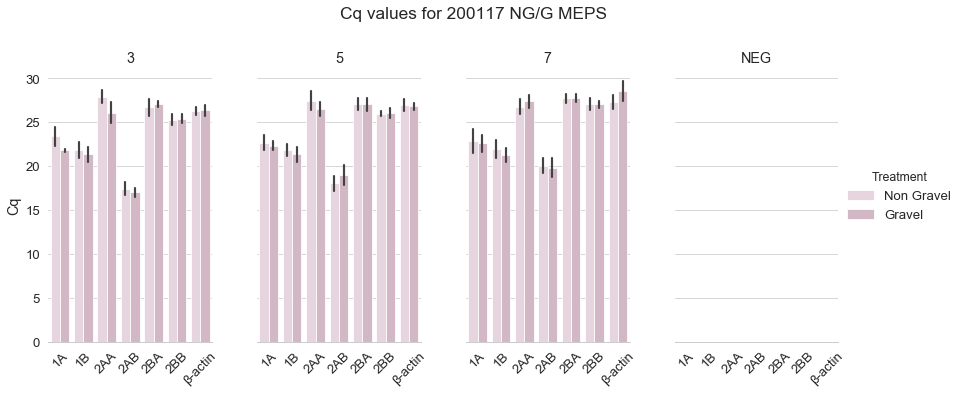

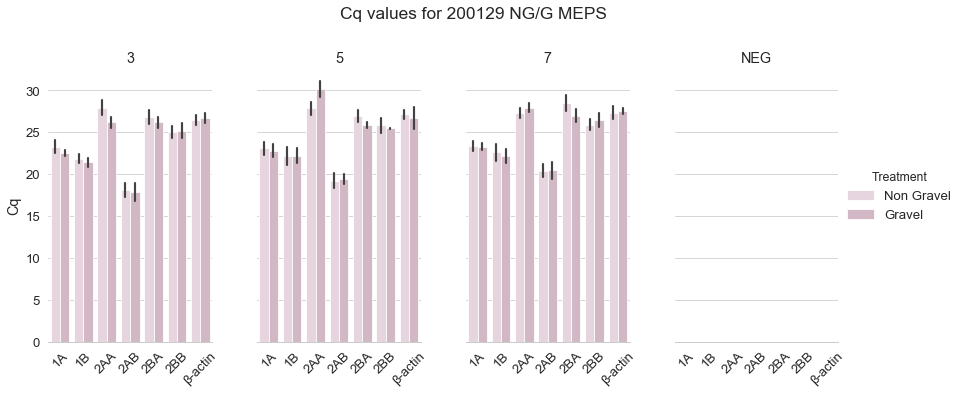

In [5]:

path_191122  = "../../Analyses/191122_qPCR/"
fname_191122 = ["191122_WT58_GRIN"]

path_200117  = "../../Analyses/200117_qPCR/"
fname_200117 = ["200117_WT58_gravel_non_gravel_pt1", "200117_WT58_gravel_non_gravel_pt2"]

path_200129  = "../../Analyses/200129_qPCR/"
fname_200129 = ["200129_WT58_gravel_non_gravel_pt1", "200129_WT58_gravel_non_gravel_pt2"]

# path_fake   = "../../Analyses/fake/"
# fname_fake  = "fake"
# fake_df     = pd.read_csv(fname, header=0)

raw_cq_200117 = plot_raw_cq(read_multi_csv(path_200117, fname_200117), '200117 NG/G MEPS', treatment = True)
# plt.suptitle("Cq values from experiment 200117")
raw_cq_200129 = plot_raw_cq(read_multi_csv(path_200129, fname_200129), '200129 NG/G MEPS', treatment = True)
# plt.suptitle("Cq values from experiment 200129")


# save = concat_df(tidy_multi_df(path_200117, fname_200117, True))
# save = tidy_multi_df(path_200117, fname_200117, True)
# save
# save.to_csv('fake.csv')

# plt.show()

In [7]:
plots_200117 =  plot_this(path_200117, fname_200117, 'BACTIN', '200117 NG/G MEPS', treatment=True)

        Sample     Cq Condition Bio Rep   Treatment
72    3_BACTIN  17.64         3       N      Gravel
73    3_BACTIN  16.99         3       N      Gravel
74    3_BACTIN  16.57         3       N      Gravel
75    5_BACTIN  20.11         5       N      Gravel
76    5_BACTIN  18.76         5       N      Gravel
77    5_BACTIN  17.79         5       N      Gravel
78    7_BACTIN  21.90         7       N      Gravel
79    7_BACTIN  20.08         7       N      Gravel
80    7_BACTIN  19.11         7       N      Gravel
81  NEG_BACTIN   0.00       NEG       N      Gravel
82  NEG_BACTIN   0.00       NEG       N      Gravel
83  NEG_BACTIN   0.00       NEG       N      Gravel
84    3_BACTIN  18.72         3       N  Non Gravel
85    3_BACTIN  17.40         3       N  Non Gravel
86    3_BACTIN  16.44         3       N  Non Gravel
87    5_BACTIN  19.42         5       N  Non Gravel
88    5_BACTIN  18.25         5       N  Non Gravel
89    5_BACTIN  17.55         5       N  Non Gravel
90    7_BACT

AttributeError: 'int' object has no attribute 'loc'

In [8]:
line = sns.lineplot(x="Age", y="RQ", hue='Target', style='Treatment', palette="rainbow", data=df_zoom)

NameError: name 'df_zoom' is not defined

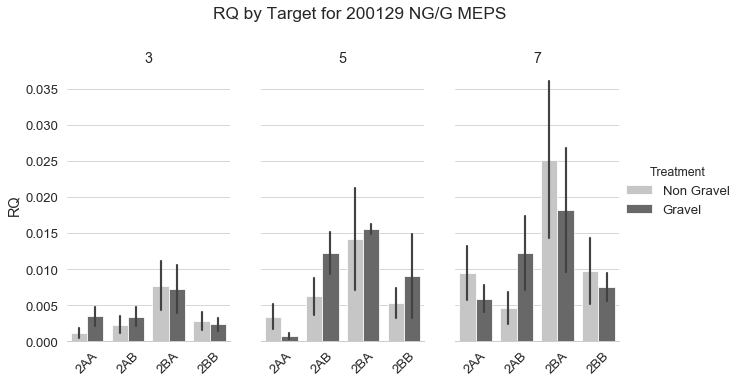

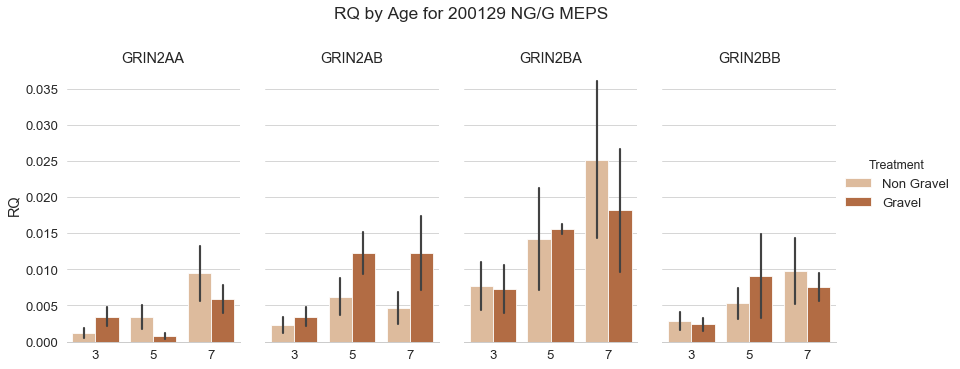

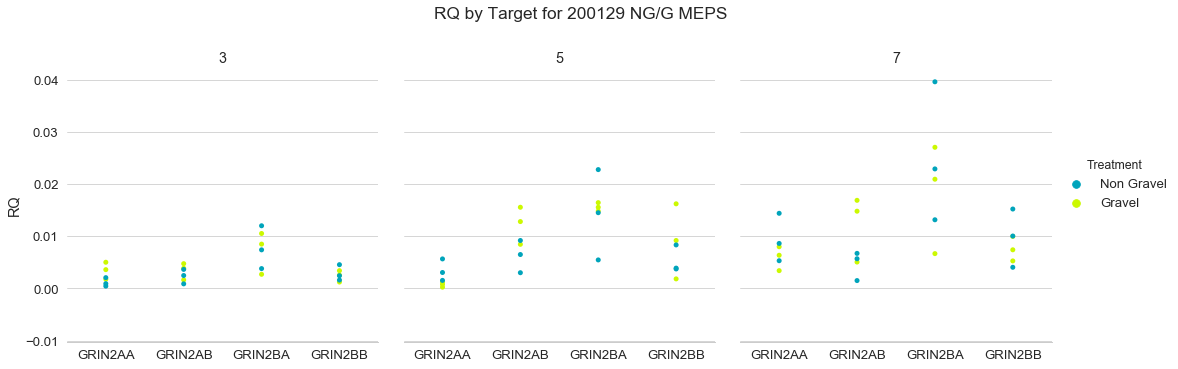

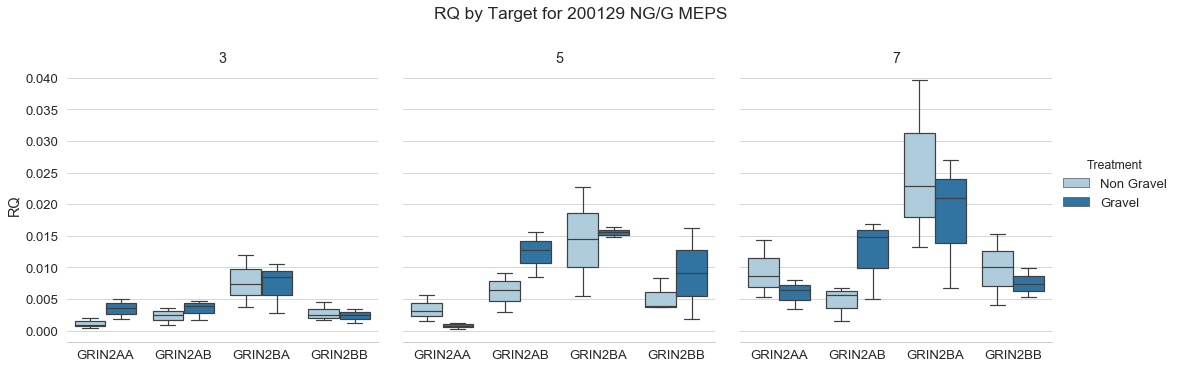

In [28]:
plots_200129 = plot_this(path_200129, fname_200129, 'BACTIN', '200129 NG/G MEPS', treatment=True)

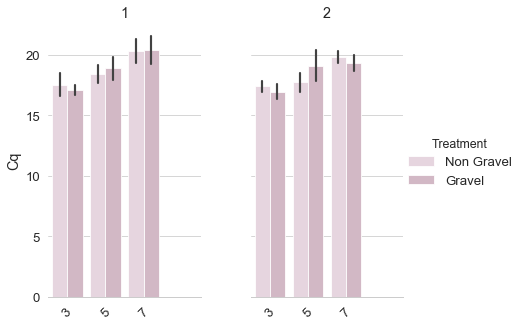

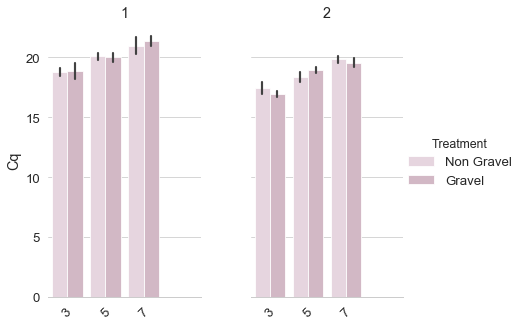

In [109]:
plot_bactin_only(path_200117, fname_200117, True)
plot_bactin_only(path_200129, fname_200129, True)


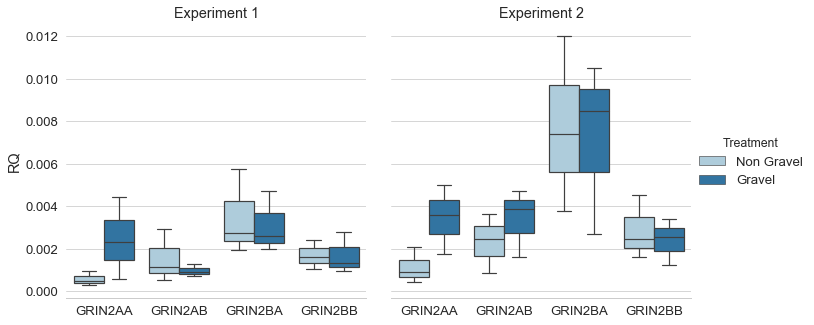

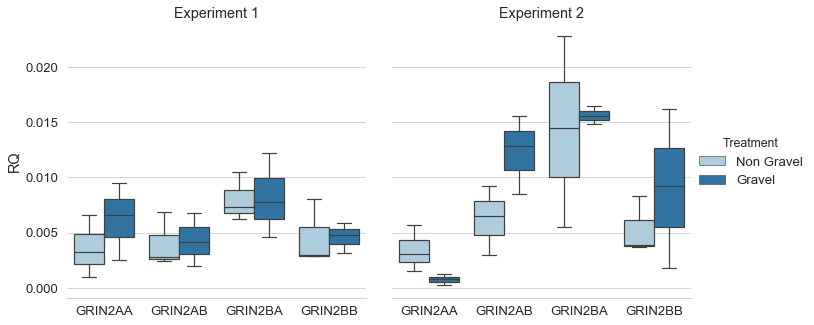

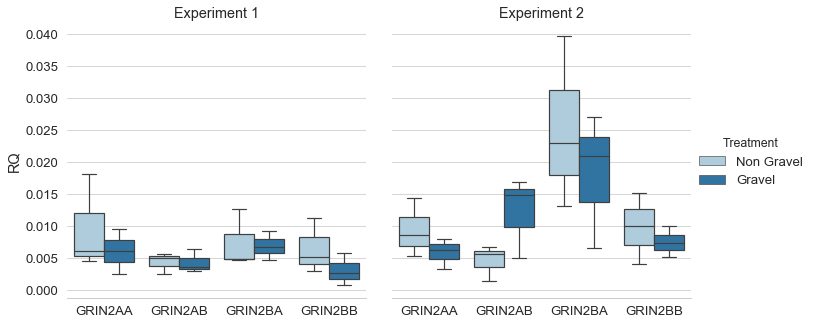

In [134]:
# path_200117   = "../../Analyses/200117_qPCR/"
# fname_200117  = ["200117_WT58_gravel_non_gravel_pt1", "200117_WT58_gravel_non_gravel_pt2"]

# path_200129   = "../../Analyses/200129_qPCR/"
# fname_200129  = ["200129_WT58_gravel_non_gravel_pt1", "200129_WT58_gravel_non_gravel_pt2"]

ex_1    = analyse_multi_df(path_200117, fname_200117, 'BACTIN', treatment=True)
ex_2    = analyse_multi_df(path_200129, fname_200129, 'BACTIN', treatment=True)

ex_1['Experiment'] = 1
ex_2['Experiment'] = 2
df = concat_df([ex_1,ex_2])


df      = strip_controls(df)
df_zoom = hide_1A_1B(df)

# boxplot = sns.catplot(x="Target", y="RQ", col="Experiment", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Paired', kind='box', data=df_zoom.query("Age == '3'"))
# (boxplot.set_axis_labels("", "RQ").set_titles("Experiment {col_name}").despine(left=True))



boxplot_3 = sns.catplot(x="Target", y="RQ", col="Experiment", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Paired', kind='box', data=df_zoom.query("Age == '3'"))
(boxplot_3.set_axis_labels("", "RQ").set_titles("Experiment {col_name}").despine(left=True))

boxplot_5 = sns.catplot(x="Target", y="RQ", col="Experiment", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Paired', kind='box', data=df_zoom.query("Age == '5'"))
(boxplot_5.set_axis_labels("", "RQ").set_titles("Experiment {col_name}").despine(left=True))

boxplot_7 = sns.catplot(x="Target", y="RQ", col="Experiment", hue='Treatment', hue_order=['Non Gravel','Gravel'], palette='Paired', kind='box', data=df_zoom.query("Age == '7'"))
(boxplot_7.set_axis_labels("", "RQ").set_titles("Experiment {col_name}").despine(left=True))


In [ ]:
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r,
OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr,
PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r,
Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r,
bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r,
gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2,
gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r,
ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r,
tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [ ]:
# def analyse_df(sample_df, ref_target, treatment=False):
#     #---------------------------------------------------------------------------------------------------------
#     """Description
    
#     :param DataFrame sample_frame: A sample data frame.
#     :param string ref_target: A string matching an entry of the Target column; reference gene;
#         the target to use as the reference target (e.g. 'BACTIN')
#     :return: A DataFrame with columns: Sample, Target, Age, DeltaCq, and Rel Exp.
#     :rtype: DataFrame
#     """
    
#     relevant_cols = ['Sample', 'Cq', 'Condition']
#     relevant_grps = ['Condition', 'Sample']
#     if treatment: relevant_cols.append('Treatment'); relevant_grps.append('Treatment')

#     if isinstance(sample_df,list): sample_df = sample_df[0]
        
#     # select relevant columns from reference gene data and find mean of technical replicates
#     ref_target_df             = sample_df.loc[sample_df['Target'] == ref_target, relevant_cols]
#     ref_target_grouped_by_age = ref_target_df.groupby(relevant_grps)
#     ref_target_mean_by_sample = ref_target_grouped_by_age.agg(amean_cq)
    
#     ref_sample_grouped_by_age = sample_df.groupby(relevant_grps)
    
#     # define conditions and initiate empty array and df
#     unique_conditions = sample_df.Condition.unique()
#     sample_dcq_series = []
#     analysed_df       = pd.DataFrame({
#                            'Sample': [],
#                            'Target': [],
#                            'Age': [],
#                            'RQ': [],
#                            'Avg RQ': [],
#                            'Treatment': []
#                           })
    
#     # iterate through unique 'conditions' i.e. ages and NEG, calculate relative quantity, and 
#     for condition, group in ref_sample_grouped_by_age:
#         for age in unique_conditions:
#             if age == condition[0]:
#                 sample         = condition[1]
                
#                 ref_mean_cq    = ref_target_mean_by_sample.loc[[age, 'average_cq']]['Cq'][0]

# #                 sample_mean_cq = amean_cq(group['Cq'])
# #                 RQ      = delta_delta_cq(ref_mean_cq,sample_mean_cq)
# #                 log2_RQ = log(RQ)
            
#                 sample_cq      = group['Cq']
#                 RQs            = delta_delta_cq(ref_mean_cq,sample_cq)#
#                 sd, sem, gmean = stats_rq(RQs)

#                 for RQ in RQs:
#                     analysed_df = analysed_df.append({
#                            'Sample'   : sample,
#                            'Target'   : group['Target'].unique()[0],
#                            'Age'      : age,
#                            'RQ'       : RQ,
#                            'Avg RQ'   : gmean,
#                            'Treatment': group['Treatment'].unique()[0]}
#                              ,ignore_index=True)


#     return analysed_df